In [46]:
import pandas as pd
import jieba
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from textblob import TextBlob
from sentence_transformers import SentenceTransformer
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# 文件读取地址
file_path = r"../data/last_words_sampled_rows.csv"

# 加载数据
try:
    data = pd.read_csv(file_path, encoding='utf-8')
except UnicodeDecodeError:
    data = pd.read_csv(file_path, encoding='gbk')

# 去除缺失值
data = data.dropna(subset=['last.statement'])

# 加载停用词
with open('../data/stop_words.txt', 'r', encoding='utf-8') as f:
    stopwords = [line.strip() for line in f.readlines()]

# 更完善的文本预处理函数
def preprocess_text(text):
    # 去除特殊字符
    text = re.sub(r'[^\w\s]', '', text)
    # 分词
    words = jieba.lcut(text)
    # 词性标注，保留形容词、副词等可能体现情感的词性
    import jieba.posseg as pseg
    words = [word for word, flag in pseg.lcut(text) if flag in ['a', 'ad', 'd'] or word not in stopwords]
    return " ".join(words)

# 对遗言进行预处理
data['last statement_preprocessed'] = data['last.statement'].apply(preprocess_text)

# 使用 TF-IDF 进行文本向量化
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(data['last statement_preprocessed'])

# 使用 BERT 进行文本向量化
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')  # 支持中英文，速度快
texts = data['last statement_preprocessed'].tolist()
X_bert = model.encode(texts, show_progress_bar=True)

# 增加情感分析特征
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

data['sentiment_score'] = data['last statement_preprocessed'].apply(get_sentiment)
X_sentiment = data['sentiment_score'].values.reshape(-1, 1)

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [47]:
X_tfidf.shape

(61, 790)

In [49]:
X_bert.shape

(61, 384)

In [16]:
# 合并特征
from scipy.sparse import hstack
X = hstack([X_tfidf, X_sentiment])
Y = data['label-penitence'].apply(lambda x: 1 if x > 0.5 else 0).tolist()

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

# 1. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

from sklearn.model_selection import GridSearchCV

# 定义参数搜索空间
param_grid = {
    'C': [0.1, 1, 10, 100],  # 增加更大的C值
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # 增加更多核函数选项
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],  # 增加具体的gamma值
    'degree': [2, 3, 4],  # 多项式核的度数
    'coef0': [0.0, 0.1, 1.0],  # 核函数中的常数项
    'class_weight': [None, 'balanced']  # 类别权重选项
}

# 建立SVC模型
svm = SVC(random_state=42)

# 建立GridSearchCV对象
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_svm = grid_search.best_estimator_

# 输出最优参数和最优分数
print("最优参数:", grid_search.best_params_)
print("最优交叉验证准确率:", grid_search.best_score_)

# 用最优模型在测试集上预测
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report
print("测试集准确率:", accuracy_score(y_test, y_pred))
print("分类报告:\n", classification_report(y_test, y_pred))

最优参数: {'C': 10, 'class_weight': 'balanced', 'coef0': 1.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'sigmoid'}
最优交叉验证准确率: 0.7666666666666667
测试集准确率: 0.6923076923076923
分类报告:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71         7
           1       0.67      0.67      0.67         6

    accuracy                           0.69        13
   macro avg       0.69      0.69      0.69        13
weighted avg       0.69      0.69      0.69        13



In [50]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# 假设 X_tfidf 是 (61, 790) 的稀疏矩阵，Y 是标签
# 划分训练集和测试集

X_train, X_test, y_train, y_test = train_test_split(X_bert, Y, test_size=0.2, random_state=42)

# 定义参数搜索空间
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],  # 增加更大的C值
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # 增加更多核函数选项
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],  # 增加具体的gamma值
    'degree': [2, 3, 4],  # 多项式核的度数
    'coef0': [0.0, 0.1, 1.0],  # 核函数中的常数项
    'class_weight': [None, 'balanced']  # 类别权重选项
}

# 建立并训练SVM模型
svm_model = SVC(random_state=42)

# 建立GridSearchCV对象
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_svm = grid_search.best_estimator_


# 预测
y_pred = best_svm.predict(X_test)

# 评估
print("SVM模型准确率:", accuracy_score(y_test, y_pred))
print("分类报告:\n", classification_report(y_test, y_pred))

SVM模型准确率: 0.8461538461538461
分类报告:
               precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.75      1.00      0.86         6

    accuracy                           0.85        13
   macro avg       0.88      0.86      0.85        13
weighted avg       0.88      0.85      0.84        13



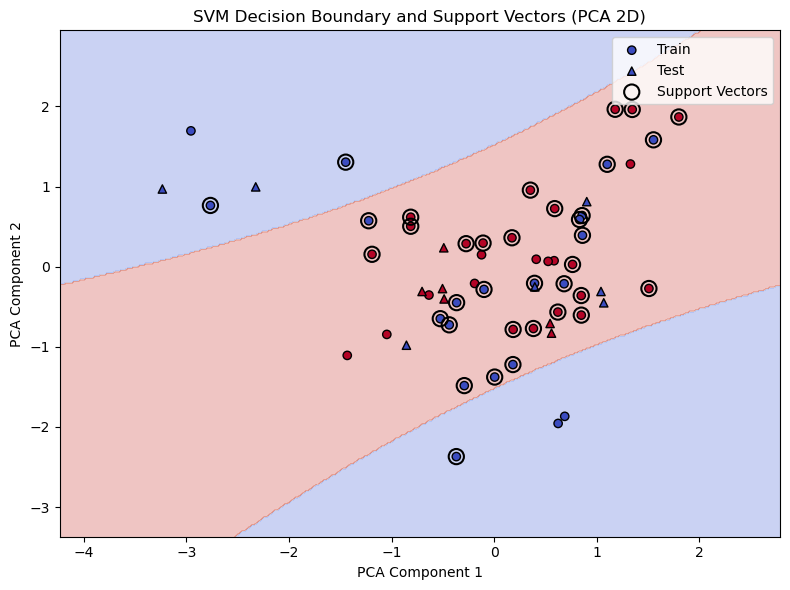

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# 将稀疏矩阵转为稠密矩阵
X_dense = X_bert.toarray() if hasattr(X_bert, "toarray") else X_bert

# 用PCA降到2维
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_dense)

# 用同样的划分获得2D训练集和测试集
X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(X_2d, Y, test_size=0.2, random_state=42)

# 用降维后的数据重新训练SVM（只用于可视化）
svm_vis = SVC(kernel=best_svm.kernel, C=best_svm.C, gamma=best_svm.gamma, degree=best_svm.degree, coef0=best_svm.coef0, class_weight=best_svm.class_weight, random_state=42)
svm_vis.fit(X_train_2d, y_train_2d)

# 画决策边界
h = .02
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = svm_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train_2d, cmap=plt.cm.coolwarm, edgecolors='k', label='Train')
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test_2d, cmap=plt.cm.coolwarm, marker='^', edgecolors='k', label='Test')
# 支持向量
plt.scatter(svm_vis.support_vectors_[:, 0], svm_vis.support_vectors_[:, 1], s=120,
            facecolors='none', edgecolors='black', linewidths=1.5, label='Support Vectors')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('SVM Decision Boundary and Support Vectors (PCA 2D)')
plt.legend()
plt.tight_layout()
plt.show()

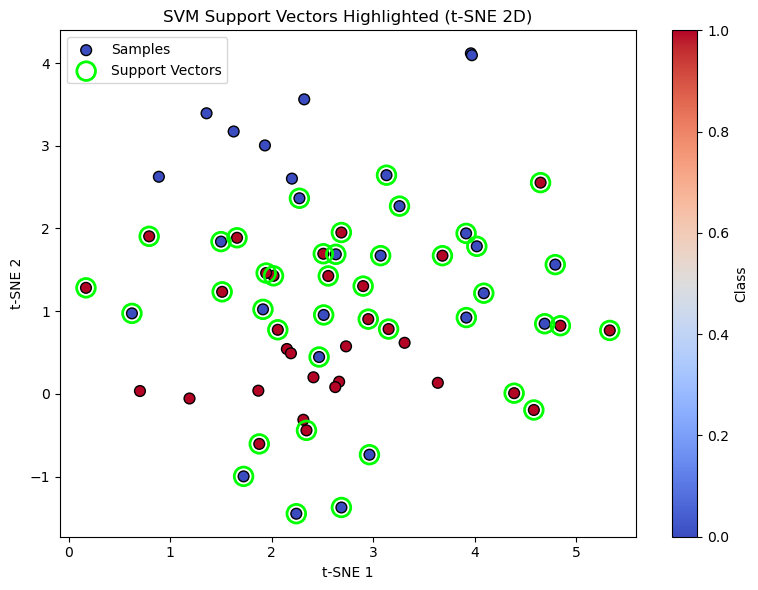

In [54]:
from sklearn.manifold import TSNE

X_dense = X_bert.toarray() if hasattr(X_bert, "toarray") else X_bert
X_2d = TSNE(n_components=2, random_state=42).fit_transform(X_dense)

svm_vis = SVC(kernel=best_svm.kernel, C=best_svm.C, gamma=best_svm.gamma, degree=best_svm.degree, coef0=best_svm.coef0, class_weight=best_svm.class_weight, random_state=42)
svm_vis.fit(X_2d, Y)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=Y, cmap=plt.cm.coolwarm, edgecolors='k', s=60, label='Samples')
plt.scatter(svm_vis.support_vectors_[:, 0], svm_vis.support_vectors_[:, 1], s=180,
            facecolors='none', edgecolors='lime', linewidths=2, label='Support Vectors')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('SVM Support Vectors Highlighted (t-SNE 2D)')
plt.legend()
plt.colorbar(scatter, label='Class')
plt.tight_layout()
plt.show()